                Anomaly Classification using Supervised Methods in wood category of MVTec dataset

In [1]:
import os
import warnings
import time
import cv2
import numpy as np
import seaborn as sns
from PIL import Image
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
warnings.filterwarnings("ignore")

# load MVTec images from a specific category structure
def load_mvtec_images(path, label):
    images = []
    labels = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                img = Image.open(os.path.join(root, file)).convert('RGB')
                img = img.resize((128, 128))
                images.append(np.array(img))
                labels.append(label)
    return np.array(images), np.array(labels).reshape(-1, 1)

# Load normal and anomalous images for a given category
def load_data(category, dataset_root='dataset/MVTec'):
    category_path = os.path.join(dataset_root, category)
    train_good_path = os.path.join(category_path, 'train', 'good')
    test_path = os.path.join(category_path, 'test')

    normal_images = []
    normal_labels = []

    # Load normal images from train/good
    print(f"Loading normal images from {train_good_path}...")
    train_normal_images, train_normal_labels = load_mvtec_images(train_good_path, 0)
    print(f"Loaded {len(train_normal_images)} normal images from {train_good_path}")
    normal_images.append(train_normal_images)
    normal_labels.append(train_normal_labels)

    # Load normal images from test/good
    test_good_path = os.path.join(test_path, 'good')
    print(f"Loading normal images from {test_good_path}...")
    test_normal_images, test_normal_labels = load_mvtec_images(test_good_path, 0)
    print(f"Loaded {len(test_normal_images)} normal images from {test_good_path}")
    normal_images.append(test_normal_images)
    normal_labels.append(test_normal_labels)

    normal_images = np.concatenate(normal_images)
    normal_labels = np.concatenate(normal_labels)

    anomalous_images = []
    anomalous_labels = []

    # Load anomalous images from all subfolders in test, except 'good'
    for subfolder in os.listdir(test_path):
        subfolder_path = os.path.join(test_path, subfolder)
        if os.path.isdir(subfolder_path) and subfolder != 'good':
            print(f"Loading anomalous images from {subfolder_path}...")
            anomaly_images, anomaly_labels = load_mvtec_images(subfolder_path, 1)
            print(f"Loaded {len(anomaly_images)} anomalous images from {subfolder_path}")
            anomalous_images.append(anomaly_images)
            anomalous_labels.append(anomaly_labels)

    anomalous_images = np.concatenate(anomalous_images)
    anomalous_labels = np.concatenate(anomalous_labels)

    print(f"Total normal images loaded: {len(normal_images)}")
    print(f"Total anomalous images loaded: {len(anomalous_images)}")

    return normal_images, normal_labels, anomalous_images, anomalous_labels

# Just Change the category that you want to train the model, Default is "wood"

category = 'wood'
normal_images, normal_labels, anomalous_images, anomalous_labels = load_data(category)
print("\nExtracted features data shapes:")
print("Extracted_good_images:", normal_images.shape, normal_labels.shape)
print("Extracted_anomalous_images:", anomalous_images.shape, anomalous_labels.shape)


Loading normal images from dataset/MVTec\wood\train\good...
Loaded 247 normal images from dataset/MVTec\wood\train\good
Loading normal images from dataset/MVTec\wood\test\good...
Loaded 19 normal images from dataset/MVTec\wood\test\good
Loading anomalous images from dataset/MVTec\wood\test\color...
Loaded 8 anomalous images from dataset/MVTec\wood\test\color
Loading anomalous images from dataset/MVTec\wood\test\combined...
Loaded 11 anomalous images from dataset/MVTec\wood\test\combined
Loading anomalous images from dataset/MVTec\wood\test\hole...
Loaded 10 anomalous images from dataset/MVTec\wood\test\hole
Loading anomalous images from dataset/MVTec\wood\test\liquid...
Loaded 10 anomalous images from dataset/MVTec\wood\test\liquid
Loading anomalous images from dataset/MVTec\wood\test\scratch...
Loaded 21 anomalous images from dataset/MVTec\wood\test\scratch
Total normal images loaded: 266
Total anomalous images loaded: 60

Extracted features data shapes:
Extracted_good_images: (266, 1

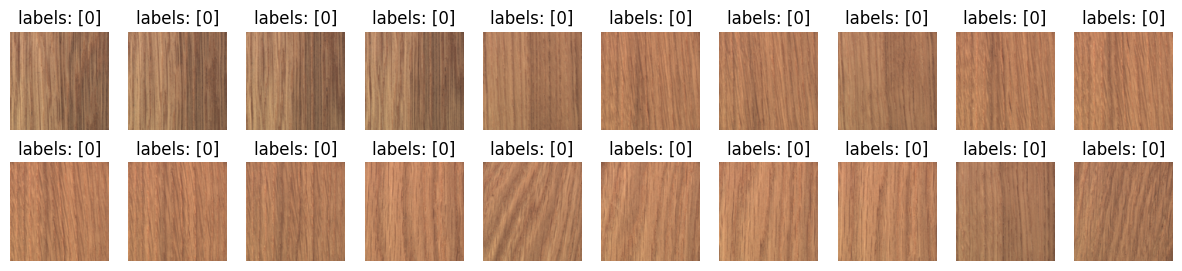

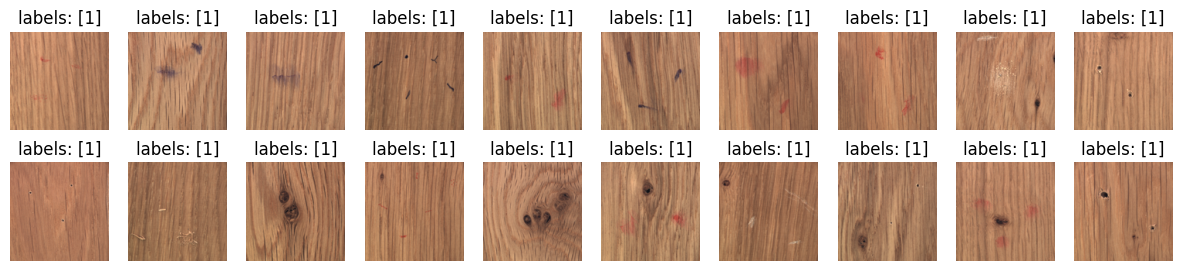

In [2]:
def plot_data(normal_images, normal_labels, n=100):
    num_rows = n // 10
    fig, axs = plt.subplots(num_rows, 10, figsize=(15, 1.5 * num_rows), gridspec_kw={'hspace': 0.3})
    axs = axs.ravel()
    for i in range(n):
        axs[i].imshow(normal_images[i])
        axs[i].set_title(f"labels: {normal_labels[i]}")
        axs[i].axis("off")
    plt.show()

plot_data(normal_images, normal_labels, 20)
plot_data(anomalous_images, anomalous_labels, 20)



In [3]:
# HOG Feature Extraction
def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Resize image to 128x128
        resized_image = cv2.resize(gray_image, (128, 128))
        
        # Extract HOG features
        fd, _ = hog(resized_image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)
        hog_features.append(fd)
    return np.array(hog_features)

# Assuming normal_images and anomalous_images are defined and contain paths to images or loaded images
normal_images_hog = extract_hog_features(normal_images)
anomalous_images_hog = extract_hog_features(anomalous_images)

print("\nExtracted HOG features data shapes:")
print("Extracted_good_images_hog:", normal_images_hog.shape, normal_labels.shape)
print("Extracted_anomalous_images_hog:", anomalous_images_hog.shape, anomalous_labels.shape)



Extracted HOG features data shapes:
Extracted_good_images_hog: (266, 512) (266, 1)
Extracted_anomalous_images_hog: (60, 512) (60, 1)


In [4]:
# Shuffle the features of each data
def shuffle_data(data, labels):
    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)
    return data[idx], labels[idx]

normal_images_hog, normal_labels = shuffle_data(normal_images_hog, normal_labels)
anomalous_images_hog, anomalous_labels = shuffle_data(anomalous_images_hog, anomalous_labels)



In [5]:
# Scale the shuffeld data to be normalized
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

normalized_images_hog = min_max_scaling(normal_images_hog)
normalized_anomalous_images_hog = min_max_scaling(anomalous_images_hog)


print("\nNormalized data shapes with HOG:")
print("normalized images using HOG:", normalized_images_hog.shape, normal_labels.shape)
print("normalized anomalous images using HOG:", normalized_anomalous_images_hog.shape, anomalous_labels.shape)




Normalized data shapes with HOG:
normalized images using HOG: (266, 512) (266, 1)
normalized anomalous images using HOG: (60, 512) (60, 1)


In [6]:
# Split data into training and testing sets for each feature extracted
X_combined_hog = np.concatenate((normalized_images_hog, normalized_anomalous_images_hog), axis=0)
y_combined_hog = np.concatenate((normal_labels, anomalous_labels), axis=0)

X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(
X_combined_hog, y_combined_hog, test_size=0.2, random_state=42, stratify=y_combined_hog
)




In [7]:
# Dimensionality reduction using PCA
def PCA(train_data, alpha=0.95):
    mean = np.mean(train_data, axis=0)
    centered_data = train_data - mean
    cov_matrix = np.dot(centered_data.T, centered_data)
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]
    total = np.sum(eig_values)
    k = 0
    var = 0
    while var / total < alpha:
        var += eig_values[k]
        k += 1
    eig_vectors = eig_vectors[:, :k]
    return eig_vectors, mean



In [8]:
# Dimensionality reduction using LDA
def LDA(train_data, train_labels, k=1, regularization=1e-5):
    mean1 = np.mean(train_data[train_labels.ravel() == 1], axis=0)
    mean0 = np.mean(train_data[train_labels.ravel() == 0], axis=0)
    Sw = np.dot((train_data[train_labels.ravel() == 1] - mean1).T, (train_data[train_labels.ravel() == 1] - mean1)) + \
         np.dot((train_data[train_labels.ravel() == 0] - mean0).T, (train_data[train_labels.ravel() == 0] - mean0))
    Sw += np.eye(Sw.shape[0]) * regularization  # Add regularization
    Sb = np.dot((mean1 - mean0).reshape(-1, 1), (mean1 - mean0).reshape(-1, 1).T)
    eig_values, eig_vectors = np.linalg.eigh(np.dot(np.linalg.inv(Sw), Sb))
    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]
    return eig_vectors[:, :k]



In [9]:
# Perform PCA on HOG features
space_pca_hog, mean_pca_hog = PCA(X_train_hog)
train_projected_pca_hog = np.dot(X_train_hog - mean_pca_hog, space_pca_hog)
test_projected_pca_hog = np.dot(X_test_hog - mean_pca_hog, space_pca_hog)

print("\nReduction features of HOG data shapes:")
print("Reduction_train_images_PCA:", train_projected_pca_hog.shape, normal_labels.shape)
print("Reduction_test_images_PCA:", test_projected_pca_hog.shape, anomalous_labels.shape)


Reduction features of HOG data shapes:
Reduction_train_images_PCA: (260, 141) (266, 1)
Reduction_test_images_PCA: (66, 141) (60, 1)


In [10]:
# Perform LDA on HOG features
lda_space_hog = LDA(X_train_hog, y_train_hog)
train_lda_projected_hog = np.dot(X_train_hog, lda_space_hog)
test_lda_projected_hog = np.dot(X_test_hog, lda_space_hog)

print("\nReduction features of HOG data shapes:")
print("Reduction_train_images_LDA:", train_lda_projected_hog.shape, normal_labels.shape)
print("Reduction_test_images_LDA:", test_lda_projected_hog.shape, anomalous_labels.shape)


Reduction features of HOG data shapes:
Reduction_train_images_LDA: (260, 1) (266, 1)
Reduction_test_images_LDA: (66, 1) (60, 1)


HOG Features - With HOG Feature Extraction - SVM
Training Time: 0.0157 seconds
Training Score: 100.0000
Testing Score: 100.0000
F1 Score: 1.0000
Cross-Validation Score: 100.0000
Best Hyperparameters - C: 0.1, Kernel: linear


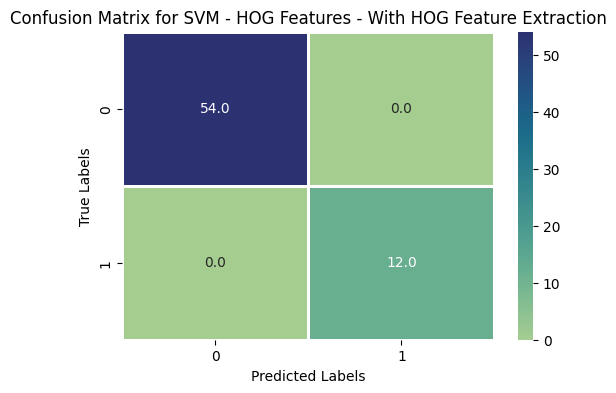

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        12

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

------------------------------------------------------------------------------------------------------------------------
HOG Features - With_PCA - SVM
Training Time: 0.0000 seconds
Training Score: 100.0000
Testing Score: 100.0000
F1 Score: 1.0000
Cross-Validation Score: 100.0000
Best Hyperparameters - C: 0.1, Kernel: linear


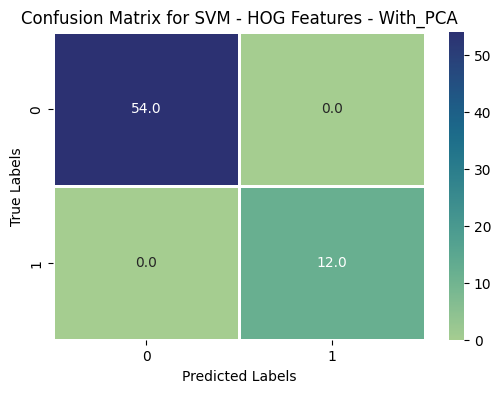

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        12

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

------------------------------------------------------------------------------------------------------------------------
HOG Features - With_LDA - SVM
Training Time: 0.0000 seconds
Training Score: 96.5385
Testing Score: 89.3939
F1 Score: 0.8878
Cross-Validation Score: 96.5385
Best Hyperparameters - C: 1, Kernel: linear


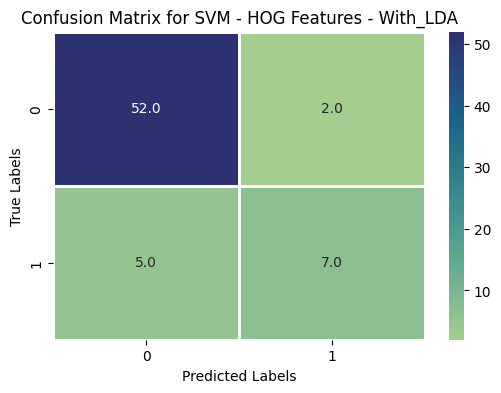

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94        54
           1       0.78      0.58      0.67        12

    accuracy                           0.89        66
   macro avg       0.85      0.77      0.80        66
weighted avg       0.89      0.89      0.89        66

------------------------------------------------------------------------------------------------------------------------
HOG Features - With HOG Feature Extraction - KNN_Classifier
Training Time: 0.0010 seconds
Training Score: 83.4615
Testing Score: 81.8182
F1 Score: 0.7364
Cross-Validation Score: 82.3077
Best Hyperparameters - n_neighbors: 3


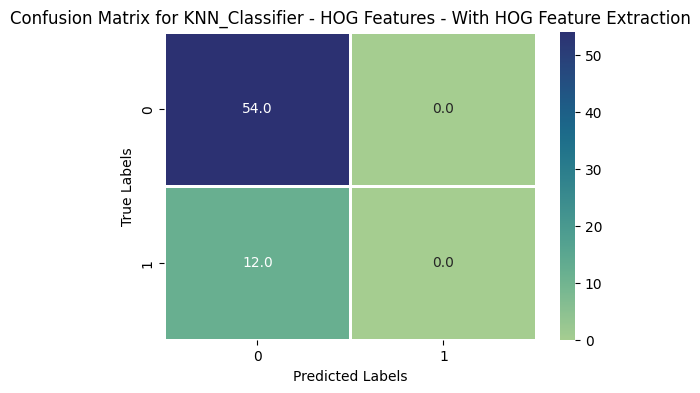

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        54
           1       0.00      0.00      0.00        12

    accuracy                           0.82        66
   macro avg       0.41      0.50      0.45        66
weighted avg       0.67      0.82      0.74        66

------------------------------------------------------------------------------------------------------------------------
HOG Features - With_PCA - KNN_Classifier
Training Time: 0.0000 seconds
Training Score: 82.6923
Testing Score: 81.8182
F1 Score: 0.7364
Cross-Validation Score: 81.9231
Best Hyperparameters - n_neighbors: 3


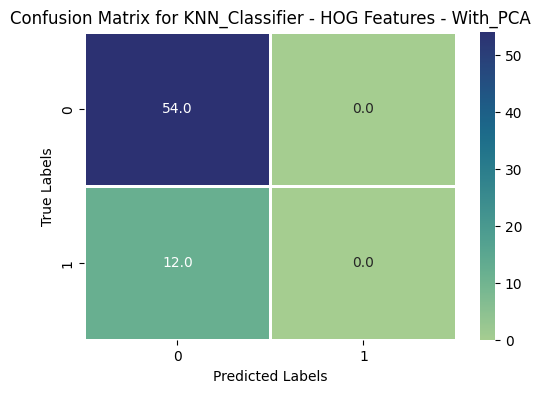

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        54
           1       0.00      0.00      0.00        12

    accuracy                           0.82        66
   macro avg       0.41      0.50      0.45        66
weighted avg       0.67      0.82      0.74        66

------------------------------------------------------------------------------------------------------------------------
HOG Features - With_LDA - KNN_Classifier
Training Time: 0.0010 seconds
Training Score: 96.9231
Testing Score: 86.3636
F1 Score: 0.8657
Cross-Validation Score: 96.5385
Best Hyperparameters - n_neighbors: 5


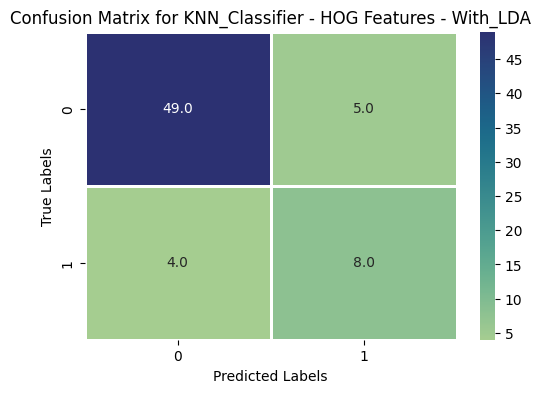

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92        54
           1       0.62      0.67      0.64        12

    accuracy                           0.86        66
   macro avg       0.77      0.79      0.78        66
weighted avg       0.87      0.86      0.87        66

------------------------------------------------------------------------------------------------------------------------
HOG Features - With HOG Feature Extraction - Gaussian_NB
Training Time: 0.0000 seconds
Training Score: 93.4615
Testing Score: 78.7879
F1 Score: 0.8083
Cross-Validation Score: 92.6923


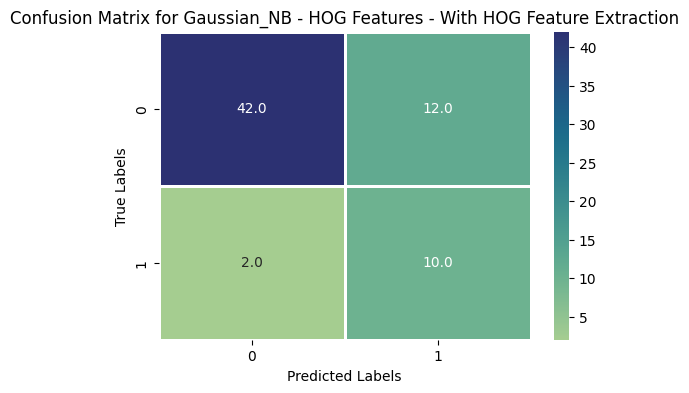

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86        54
           1       0.45      0.83      0.59        12

    accuracy                           0.79        66
   macro avg       0.70      0.81      0.72        66
weighted avg       0.86      0.79      0.81        66

------------------------------------------------------------------------------------------------------------------------
HOG Features - With_PCA - Gaussian_NB
Training Time: 0.0010 seconds
Training Score: 99.2308
Testing Score: 87.8788
F1 Score: 0.8527
Cross-Validation Score: 96.9231


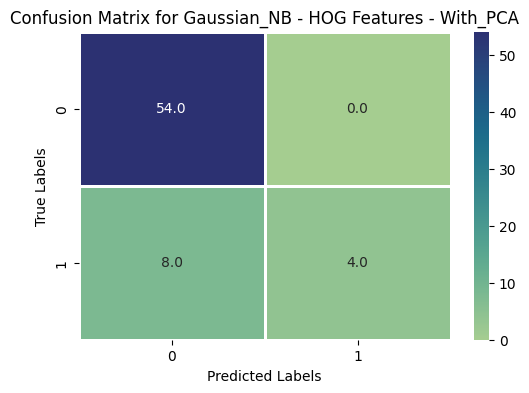

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        54
           1       1.00      0.33      0.50        12

    accuracy                           0.88        66
   macro avg       0.94      0.67      0.72        66
weighted avg       0.89      0.88      0.85        66

------------------------------------------------------------------------------------------------------------------------
HOG Features - With_LDA - Gaussian_NB
Training Time: 0.0010 seconds
Training Score: 96.1538
Testing Score: 86.3636
F1 Score: 0.8613
Cross-Validation Score: 96.1538


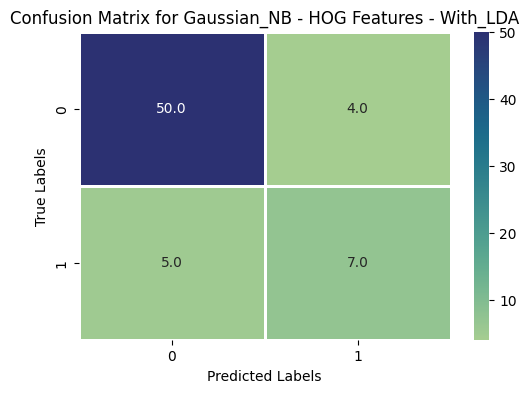

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        54
           1       0.64      0.58      0.61        12

    accuracy                           0.86        66
   macro avg       0.77      0.75      0.76        66
weighted avg       0.86      0.86      0.86        66

------------------------------------------------------------------------------------------------------------------------

The Best model is: SVM with With HOG Feature Extraction method, having an F1 score of 1.0000
Hyperparameters: C: 0.1, Kernel: linear




In [11]:

# Create a list of classifier instances with hyperparameter grids for tuning
classifiers = [
    ("SVM", SVC(), {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}),
    ("KNN_Classifier", KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9]}),
    ("Gaussian_NB", GaussianNB(), {})
]

# Initialize lists to store classifier names, training accuracies, test accuracies, and F1-scores
classifier_names = []
train_accuracies = []
test_accuracies = []
f1_scores = []
training_times = []
hyperparameters = []

X_for_training_hog = [X_train_hog, train_projected_pca_hog, train_lda_projected_hog]
X_for_test_hog = [X_test_hog, test_projected_pca_hog, test_lda_projected_hog]


text = ['With HOG Feature Extraction', 'With_PCA', 'With_LDA']

# Function to perform cross-validation and hyperparameter tuning
def evaluate_classifier(name, classifier, param_grid, X_train, X_test, y_train, y_test, feature_text):
    # Hyperparameter tuning
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train.ravel())
    best_classifier = grid_search.best_estimator_
    
    # Cross-validation
    cross_val_scores = cross_val_score(best_classifier, X_train, y_train.ravel(), cv=5)
    mean_cross_val_score = cross_val_scores.mean()
    
    # Fit the best classifier
    start_time = time.time()
    best_classifier.fit(X_train, y_train.ravel())
    training_time = time.time() - start_time
    
    # Predict and evaluate
    y_pred = best_classifier.predict(X_test)
    train_score = best_classifier.score(X_train, y_train)
    test_score = best_classifier.score(X_test, y_test)
    current_f1_score = f1_score(y_test, y_pred, average='weighted')
    
    # Print the results
    print(f"{feature_text} - {name}")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Training Score: {train_score * 100:.4f}")
    print(f"Testing Score: {test_score * 100:.4f}")
    print(f"F1 Score: {current_f1_score:.4f}")
    print(f"Cross-Validation Score: {mean_cross_val_score * 100:.4f}")
    
    if name == "SVM":
        print(f"Best Hyperparameters - C: {grid_search.best_params_['C']}, Kernel: {grid_search.best_params_['kernel']}")
        hyperparameters.append(f"C: {grid_search.best_params_['C']}, Kernel: {grid_search.best_params_['kernel']}")
    elif name == "KNN_Classifier":
        print(f"Best Hyperparameters - n_neighbors: {grid_search.best_params_['n_neighbors']}")
        hyperparameters.append(f"n_neighbors: {grid_search.best_params_['n_neighbors']}")
    else:
        hyperparameters.append("N/A")
    
    # Append results to lists
    classifier_names.append(name)
    train_accuracies.append(train_score)
    test_accuracies.append(test_score)
    f1_scores.append(current_f1_score)
    training_times.append(training_time)
    
    # Plot the confusion matrix
    conmat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conmat, annot=True, fmt=".1f", linewidth=1, cmap="crest")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {name} - {feature_text}")
    plt.show()
    
    # Print the classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)
    print("-" * 120)

# Evaluate classifiers on HOG features
for name, classifier, param_grid in classifiers:
    for i in range(len(text)):
        evaluate_classifier(name, classifier, param_grid, X_for_training_hog[i], X_for_test_hog[i], y_train_hog, y_test_hog, f"HOG Features - {text[i]}")

# Print the best model information
best_model_info = {'name': None, 'feature_extraction': None, 'f1_score': 0, 'hyperparameters': None}
for name, feature_extraction, f1, params in zip(classifier_names, [text[i % len(text)] for i in range(len(classifier_names))], f1_scores, hyperparameters):
    if f1 > best_model_info['f1_score']:
        best_model_info['name'] = name
        best_model_info['feature_extraction'] = feature_extraction
        best_model_info['f1_score'] = f1
        best_model_info['hyperparameters'] = params

print(f"\nThe Best model is: {best_model_info['name']} with {best_model_info['feature_extraction']} method, having an F1 score of {best_model_info['f1_score']:.4f}")
print(f"Hyperparameters: {best_model_info['hyperparameters']}\n\n")
